In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from compare_tools.hathimeta import HathiMeta, get_json_meta
from compare_tools.configuration import config, init_htid_args
from compare_tools.comparison import Comparison, HTIDComparison
from compare_tools.utils import HTID
htid_args = init_htid_args(config)

In [3]:
config

{'rsync_root': '/drobo/feature-counts',
 'meta_path': '/drobo/hathi-test-dataset/test_dataset.csv.gz',
 'metadb_path': '/drobo/hathi-test-dataset/test_dataset.sqlite',
 'scratch': '/drobo/scratch/',
 'parquet_root': '/drobo/hathi-parquet',
 'parquet_chunked_root': '/drobo/hathi-parquet-chunked',
 'resolver': [{'dir': '/home/bschmidt/hathi-parquet',
   'format': 'parquet',
   'compression': 'gzip',
   'index': False,
   'indexed': False,
   'cache': True,
   'token_kwargs': {'pos': False, 'section': 'body', 'drop_section': True}},
  {'dir': '/home/bschmidt/hathi-ef',
   'format': 'json',
   'compression': 'bz2',
   'id_resolver': 'pairtree'}]}

In [4]:
import pandas as pd
test = pd.read_csv("http://35.239.220.133/download")

In [5]:
import random
k = random.randint(0, test.shape[0])
g = test.iloc[k]
ids =  [g['target'].replace("=", "/"),g['candidate'].replace("=", "/")] 
print(g)

Unnamed: 0                            2
rater                              Rita
target        coo1.ark:/13960=t5j96qx1s
candidate            msu.31293000712699
judgment                           SWSM
notes                               NaN
timestamp                   1.58078e+09
Name: 1021, dtype: object


In [6]:
test.groupby("judgment").count()

,Unnamed: 0,rater,target,candidate,notes,timestamp
judgment,,,,,,
AUTHOR,1291,1291,1291,1291,16,1291
CONTAINS,13,13,13,13,4,13
DIFF,44,44,44,44,2,44
Other,9,9,9,9,9,9
PARTOF,26,26,26,26,1,26
SWDE,216,216,216,216,32,216
SWSM,282,282,282,282,21,282
TO_DISCUSS,6,6,6,6,6,6
UNKNOWN,3,3,3,3,0,3


This notebooks demonstrates page-level Jaccard similarity. This an expensive procedure, but useful as a ground truth.

The algorithms for extracting runs operate on the Jaccard similarity matrix for pages the same way they do on GloVe or SRP
matrices for chunked books.

Some test code to explore vol and page methods. Can be cut.

In [7]:
SWDE = ["hvd.hc4btz", "uc1.$b306620"]

In [8]:
comp = HTIDComparison(ids = SWDE, **htid_args)

In [9]:
# Force loading of metadata
_ = [comp.left.volume, comp.right.volume]


In [10]:
comp

In [11]:
scope = "page"

I find 0.2 to be a reasonable threshold for Jaccard similarity. As you see here, there are many page-comparison pairs that reach 0.2 similarity (maybe largely short pages?) but the main run of similarity is successfully extracted.

Here are some statistics about this comparison.A brief explanation:

* mean_page_diff looks at runs and pulls the average page difference in absolute numbers. If this is zero, it's a strong sign of SWSM; if this is very high, it's a strong sign of enclosure or some other relationship where runs are offset by tens or hundreds of pages.
* sd_page_diff is how much the page difference within runs varies. Again, low values indicate SWSM.
* mean_similarity_inside_of_runs is Jaccard sim in runs.
* mean_similarity_to_right_of_runs is Jaccard sim immediately to the right of runs in the adjacency matrix. If there are high, it indicates some closeness.
* share_l_in_r and share_r_in_l give some enclosure stats for finding enclosure.
* overall_slope gives the slope of a linear model fitted to all run pairs.
* weighted_in_run_page_slope is the average slope of the pagewise matches. if this is one, it indicates that the runs are always up and to the left.
* weighted_in_run_word_slope is the slope adjusting for word lengths. This is a funny proxy to catch if the word counts are different between the books.
* sim_at_{X}_length captures the similarity score for the weighted matrix at four points relative to the shorter of the two books. See below

In [12]:
comp.jaccard_stats(scope)

/home/bschmidt/miniconda3/envs/htrc/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


{'mean_page_diff': 19.22519083969466,
 'sd_page_diff': 10.64971960857273,
 'mean_similarity_inside_runs': 0.8702928492291394,
 'mean_similarity_to_right_of_runs': 0.05513177413258112,
 'share_l_in_r': 0.9290780141843972,
 'share_r_in_l': 0.8291139240506329,
 'overall_slope': 0.8730099481359812,
 'strength_of_overall_fit': 0.9991439007813,
 'weighted_in_run_page_slope': 1.0,
 'weighted_in_run_word_slope': 1.102058590713454,
 'sim_at_quarter_length': 0.9369369369369369,
 'sim_at_half_length': 0.896551724137931,
 'sim_at_full_length': 0.18181818181818182,
 'sim_at_double_length': 0.0825242718446602}

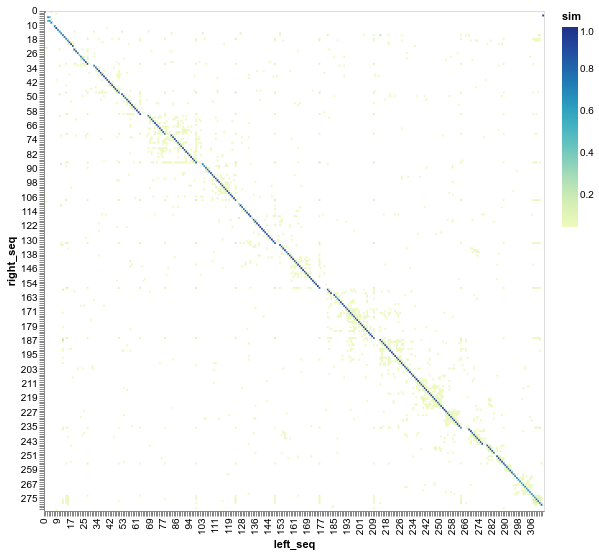

In [13]:
# This will only work if `jaccard_stats` is run before, because it needs the runs in place.
comp.plot("jaccard_matrix", scope=scope, filter = lambda x: x >= 0.05, runs = False).properties(width=500, height=500)


The fraction capture the charts we were making earlier of ordered similarity.

I would like to figure out how to parameterize these, but instead just pick the points at .25, .5, 1, and 2 in the chart below or their equivalent. I'm not sure those are the best choices.

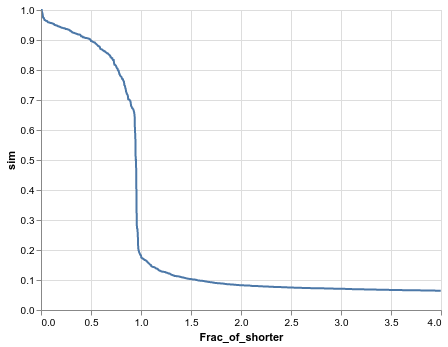

In [14]:
import altair as alt
import numpy as np
flat = comp.four_points(raw_data = True)

c = alt.Chart(pd.DataFrame({'sim': flat, 'Frac_of_shorter':np.arange(len(flat))/(len(flat)/ 4)})).mark_line()
c.encode(y='sim', x = 'Frac_of_shorter')
